Implementation of neural network based on 
Qiang Liu and Dilin Wang, [*Stein Variational Gradient Descent (SVGD): A General Purpose Bayesian Inference Algorithm*](https://arxiv.org/pdf/1608.04471.pdf), NIPS, 2016."

In [28]:
import torch
import random
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions.gamma import Gamma
from torch.optim import Adam
from torch.optim import Adagrad
from sklearn.model_selection import train_test_split

In [29]:
class RBF(torch.nn.Module):
    def __init__(self, h=-1):
        super(RBF, self).__init__()
        self.h = h
    
    def forward(self, theta):
        #theta shape 
        theta_i = theta[:,None,:]  #shape (N,D) -> N,1,D
        theta_j = theta[None, :,:] #shape (N,D) -> 1,N,D
        
        pairwise_dists = torch.norm((theta_i - theta_j),dim=2).pow(2)  #[i-j]^2 i-j.shape = (N,N,D)
        #print(pairwise_dists.shape) N,N
        #pairwise_dists = torch.norm(theta[:,None,:] - theta, dim=2).pow(2)
        h = self.h
        if(h<0):
            #do the meadian trick
            #h = np.median(pairwise_dists)
            p_dists = pairwise_dists.detach().flatten()
            h=torch.median(p_dists)
            #h = torch.median(p_dists)/np.log(theta.shape[0])
            h = torch.sqrt(0.5*h/np.log(theta.shape[0]+1))

        #compute the rbf kernel
        Kxy = torch.exp(-pairwise_dists / h**2 / 2)
        
        return Kxy,h

     
    def update(self, model, theta):
        n = theta.shape[0]
        theta = theta.detach().requires_grad_(True)

        logp = model.logp(theta)   
        dlogp = torch.autograd.grad(logp.sum(), theta)[0] 

        Kxy, h = self.forward(theta)
        
        dxKxy = torch.autograd.grad(Kxy.sum(), theta)[0]/(h ** 2)

        dxKxy = -(Kxy.mm(dlogp) + dxKxy) / n #question to the original code

        return dxKxy    
           

In [30]:
class svgd_nn:
    '''
    define a one hidden-layer neural network
    Input:
    batch size, iter, M, n_hiddenm a0, b0, master_stepsize
    In the paper, they take 1 hidden layer with 50 units, 
    the results are averaged over 20 random trials. 
    Use ReLu as activa function
    Use AdaGrad with momentum, 20 particles.
    Mini-batch size is 100
    '''
    def __init__(self, X, y, batch_size, n_hidden, max_iter,  M, a0=1.0, b0=0.1):#, a0, b0, master_stepsize):
        super(svgd_nn, self).__init__()
        
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.M = M
        self.d = X.shape[1]
        self.a0 = a0
        self.b0 = b0
        
    def forward(self, x, theta):
        ##w1: d*n_hidden; b1: n_hidden; w2 = n_hidden; b2 = 1; 2 variances
        w1 = theta[:, 0:self.d * self.n_hidden].reshape(-1, self.d, self.n_hidden)
        b1 = theta[:, self.d * self.n_hidden:(self.d + 1) * self.n_hidden].unsqueeze(1)
        w2 = theta[:, (self.d + 1) * self.n_hidden:(self.d + 2) * self.n_hidden].unsqueeze(2)
        b2 = theta[:, -3].reshape(-1, 1, 1)
        
        x = x.unsqueeze(0).repeat(self.M, 1,1)  #need to do forward for all particles
        x = F.relu(torch.bmm(x,w1)+b1)
        x = torch.bmm(x,w2)+b2
        y = x.squeeze()
        return y
        
    def logp(self, theta):
        '''
        p(y | W, X, \gamma) = \prod_i^N  N(y_i | f(x_i; W), \gamma^{-1})
        p(W | \lambda) = \prod_i N(w_i | 0, \lambda^{-1})
        p(\gamma) = Gamma(\gamma | a0, b0) 
        p(\lambda) = Gamma(\lambda | a0, b0)
    
        The posterior distribution is as follows:
        p(W, \gamma, \lambda) = p(y | W, X, \gamma) p(W | \lambda) p(\gamma) p(\lambda) 
        '''
        #prepare parameters
        log_gamma = torch.exp(theta[:, -2])  #variance related to gamma
        log_lambda = torch.exp(theta[:, -1])
    
        
        #p(\gamma) = Gamma(\gamma | a0, b0) 
        p_gamma = Gamma(torch.tensor(self.a0, device=device), torch.tensor(1/self.b0, device = device))
        p_lambda = Gamma(torch.tensor(self.a0, device=device), torch.tensor(1/self.b0, device = device))

        
        #get different distributions
        #p(W | \lambda) = \prod_i N(w_i | 0, \lambda^{-1})
        w = theta[:, :-1]
        #p_w = Normal(0, torch.ones_like(log_lambda) / log_lambda)
        p_w = Normal(0, torch.sqrt(torch.ones_like(log_lambda) / log_lambda))

        #p(y | W, X, \gamma) = \prod_i^N  N(y_i | f(x_i; W), \gamma^{-1})
        batch_index = random.sample([i for i in range(self.X.shape[0])], self.batch_size)#mini batch with random idx
        X_batch, y_batch  = self.X[batch_index],self.y[batch_index]               
        outputs = self.forward(X_batch, theta)  #apply the network,[M, batch_size]
        
        pgamma_repeat = log_gamma.unsqueeze(1).repeat(1, self.batch_size)    
        y_batch_repeat = y_batch.unsqueeze(0).repeat(self.M, 1)
        p_y = Normal(outputs, torch.sqrt(torch.ones_like(pgamma_repeat) / pgamma_repeat))
        log_p_y = p_y.log_prob(y_batch_repeat).sum(dim=1)

        log_p0 = p_w.log_prob(w.t()).sum(dim=0) + p_gamma.log_prob(log_gamma) + p_lambda.log_prob(log_lambda)
        log_p = log_p_y * (self.X.shape[0] / self.batch_size) +  log_p0
        # algorithm 1,equation 8
        return log_p
        
    

In [31]:
def test(model, X_test, y_test, theta):
    ##test
    temp = model.forward(X_test, theta)
    y_pred = temp.mean(dim=0) #take mean over particles
    rmse_test = torch.norm(y_pred - y_test)/math.sqrt(y_test.shape[0])

    print(rmse_test)
    return rmse_test

In [32]:
print("start")
if __name__ == '__main__':
    device = torch.device('cpu')
    "load data file"
    data = np.loadtxt("boston_housing")
    #print(data.shape)
    X_input = data[ :, range(data.shape[1] - 1) ] #input
    y_input = data[ :, data.shape[1] - 1 ] #result
    X_input = torch.from_numpy(X_input).float().to(device)
    y_input = torch.from_numpy(y_input).float().to(device)
    
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.1, random_state=1)
    X_train_mean, X_train_std = torch.mean(X_train, dim=0), torch.std(X_train, dim=0)
    y_train_mean, y_train_std = torch.mean(y_train, dim=0), torch.std(y_train, dim=0)
    
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std
    
    M, batch_size, n_hidden = 100, 100, 50
    n_iter = 5000
    a0 =1.0
    b0 = 0.1
    gamma = np.random.gamma(a0, b0)
    lambdas = np.random.gamma(a0, b0)

    model = svgd_nn(X_train, y_train, batch_size, n_hidden, n_iter,  M, a0, b0)
    kernel = RBF(h=-1)

    theta = torch.cat(
        [torch.zeros([M, X_train.shape[1] * n_hidden ], device=device).normal_(0, math.sqrt(n_hidden)),
         torch.zeros([M, n_hidden ], device=device),
         torch.zeros([M, n_hidden ], device=device).normal_(0, math.sqrt(X_train.shape[1])),
         torch.zeros([M, 1], device=device),
         torch.log(0.1 * torch.ones([M, 2], device=device))], dim=1)
         #torch.log(gamma * torch.ones([M, 1], device=device)),
         #torch.log(lambdas * torch.ones([M, 2], device=device))], dim=1)
        
    rmse = []
    epochs=[]
    for epoch in range(n_iter):
        optimizer = Adagrad([theta], lr=1e-3)
        optimizer.zero_grad()
        theta.grad = kernel.update(model, theta)
        optimizer.step()
        if epoch % 100 == 0:
            rmse_t = test(model, X_test, y_test, theta)
            rmse.append(rmse_t)
            epochs.append(epoch)
    
    test(model, X_test, y_test, theta)


start
tensor(52.7127)
tensor(43.4837)
tensor(36.1436)
tensor(31.0788)
tensor(27.2600)
tensor(24.0303)
tensor(21.1135)
tensor(18.7325)
tensor(16.7910)
tensor(15.3205)
tensor(13.8938)
tensor(12.6646)
tensor(11.5130)
tensor(10.5810)
tensor(9.7189)
tensor(9.1096)
tensor(8.4522)
tensor(7.7767)
tensor(7.2525)
tensor(6.7571)
tensor(6.3959)
tensor(6.0705)
tensor(5.7658)
tensor(5.5300)
tensor(5.3229)
tensor(5.0879)
tensor(4.8957)
tensor(4.7296)
tensor(4.6065)
tensor(4.4600)
tensor(4.3417)
tensor(4.2255)
tensor(4.1028)
tensor(3.9901)
tensor(3.8388)
tensor(3.7584)
tensor(3.6638)
tensor(3.5563)
tensor(3.4396)
tensor(3.3443)
tensor(3.2902)
tensor(3.1838)
tensor(3.1089)
tensor(3.0623)
tensor(2.9723)
tensor(2.9287)
tensor(2.8744)
tensor(2.8231)
tensor(2.7651)
tensor(2.7122)
tensor(2.6476)


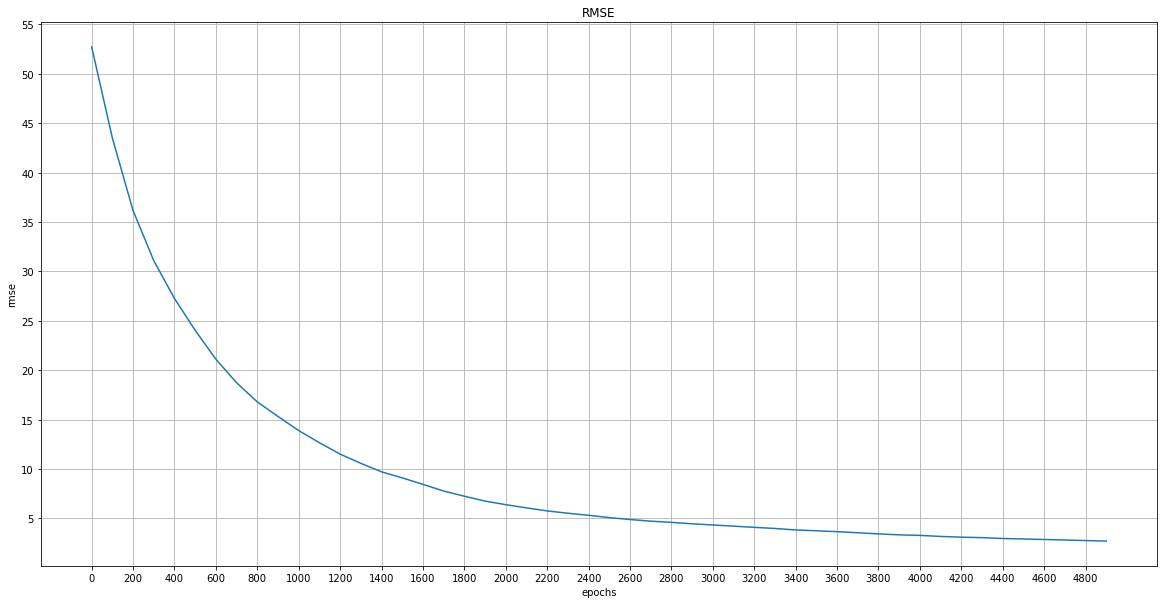

In [46]:
#plot rmse
import numpy as np 
from matplotlib import pyplot as plt 

 
plt.figure(figsize=(20,10))
plt.title("RMSE") 
plt.xlabel("epochs") 
plt.ylabel("rmse")
ax = plt.gca()
ax.set_xticks(np.arange(0, 5000, 200))
ax.set_yticks(np.arange(0, 60, 5))
plt.grid()
plt.plot(epochs,rmse) 
plt.show()